In [2]:
!pip install ucimlrepo
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt

# === DATA LOADING ===
combined_cycle_power_plant = fetch_ucirepo(id=294)
X = combined_cycle_power_plant.data.features
y = combined_cycle_power_plant.data.targets
X = X.values
y = y.values

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
def dm2comp(dm):
    return dm[:, :, 0], dm[:, :, 1:]

def comp2dm(w, v):
    # Asegurar que w es 2D: (batch_size, n_comp)
    if len(w.shape) > 2:
        w = keras.ops.squeeze(w, axis=-2)  # Elimina la dimensión extra si existe

    # Expandir para (batch_size, n_comp, 1)
    w_expanded = keras.ops.expand_dims(w, axis=-1)

    # Repetir v si hace falta
    if len(v.shape) == 3 and v.shape[0] == 1:
        v = keras.ops.repeat(v, keras.ops.shape(w)[0], axis=0)

    return keras.ops.concatenate([w_expanded, v], axis=-1)



def pure2dm(psi):
    ones = keras.ops.ones_like(psi[:, 0:1])
    return keras.ops.concatenate((ones[:, np.newaxis, :], psi[:, np.newaxis, :]), axis=2)

def dm_rbf_loglik(x, dm, sigma):
    d = keras.ops.shape(x)[-1]
    w, v = dm2comp(dm)
    dist = keras.ops.sum((x[:, np.newaxis, :] - v) ** 2, axis=-1)
    log_likelihood = keras.ops.log(
        keras.ops.einsum('...i,...i->...', w, keras.ops.exp(-dist / (2 * sigma ** 2)) ** 2) + 1e-12
    )
    coeff = d * keras.ops.log(sigma + 1e-12) + d * np.log(np.pi) / 2
    return log_likelihood - coeff

def dm_rbf_expectation(dm):
    w, v = dm2comp(dm)
    return keras.ops.einsum('...i,...ij->...j', w, v)

def dm_rbf_variance(dm, sigma):
    sigma = sigma / keras.ops.sqrt(2)
    w, v = dm2comp(dm)
    d = keras.ops.shape(v)[-1]
    squared_norms = keras.ops.sum(v ** 2, axis=-1)
    weighted_squared_norms = keras.ops.einsum('...i,...i->...', w, squared_norms)
    weighted_means = keras.ops.einsum('...i,...ij->...j', w, v)
    squared_means = keras.ops.sum(weighted_means ** 2, axis=-1)
    return weighted_squared_norms - squared_means + d * (sigma ** 2)

def gauss_entropy_lb(d, sigma):
    return (d / 2.0) * (1.0 + keras.ops.log(2.0 * np.pi * (sigma ** 2)))


In [14]:
class RBFKernelLayer(keras.layers.Layer):
    def __init__(self, sigma=0.1, dim=2, trainable=True, min_sigma=1e-3):
        super().__init__()
        self.sigma = self.add_weight(
            shape=(), initializer=keras.initializers.constant(sigma),
            trainable=trainable, name="sigma")
        self.min_sigma = min_sigma
        self.dim = dim

    def call(self, x, y):
        dist = keras.ops.sum((x[:, np.newaxis, :] - y) ** 2, axis=-1)
        return keras.ops.exp(-dist / (2 * self.sigma ** 2))

class KDMLayer(keras.layers.Layer):
    def __init__(self, kernel, dim_x, dim_y, n_comp, x_train=True, y_train=True, w_train=True, generative=0.):
        super().__init__()
        self.kernel = kernel
        self.n_comp = n_comp
        self.generative = generative
        self.c_x = self.add_weight(shape=(n_comp, dim_x), initializer="random_normal", trainable=x_train)
        self.c_y = self.add_weight(shape=(n_comp, dim_y), initializer="random_normal", trainable=y_train)
        self.c_w = self.add_weight(shape=(n_comp,), initializer="ones", trainable=w_train)

    def call(self, rho_x):
        w_x, v_x = dm2comp(rho_x)
        k = self.kernel(v_x, self.c_x)
        k = k / (keras.ops.sum(k, axis=-1, keepdims=True) + 1e-12)
        if self.generative > 0.:
            w_y = keras.ops.ones_like(k) / self.n_comp
        else:
            w_y = k
        v_y = self.c_y[None, :, :]
        return comp2dm(w_y, v_y)

class KDMRegressModel(keras.Model):
    def __init__(self, encoded_size, dim_y, encoder, n_comp, sigma_x=0.1, min_sigma_x=1e-3,
                 sigma_y=0.1, min_sigma_y=1e-3, x_train=True, y_train=True, w_train=True,
                 generative=0., entropy_reg_x=0., sigma_x_trainable=True, sigma_y_trainable=True, **kwargs):
        super().__init__(**kwargs)
        self.dim_y = dim_y
        self.encoded_size = encoded_size
        self.encoder = encoder
        if generative > 0.:
            encoder.trainable = False
        self.entropy_reg_x = entropy_reg_x
        self.n_comp = n_comp
        self.kernel = RBFKernelLayer(sigma=sigma_x, dim=encoded_size, trainable=sigma_x_trainable, min_sigma=min_sigma_x)
        self.kdm = KDMLayer(kernel=self.kernel, dim_x=encoded_size, dim_y=dim_y, n_comp=n_comp,
                            x_train=x_train, y_train=y_train, w_train=w_train, generative=generative)
        self.sigma_y = self.add_weight(shape=(), initializer=keras.initializers.constant(sigma_y),
                                       trainable=sigma_y_trainable, name="sigma_y")
        self.min_sigma_y = min_sigma_y

    def call(self, input):
        encoded = self.encoder(input)
        rho_x = pure2dm(encoded)
        rho_y = self.kdm(rho_x)
        self.sigma_y.assign(keras.ops.clip(self.sigma_y, self.min_sigma_y, np.inf))
        return rho_y

    def predict_reg(self, input, **kwargs):
        rho_y = self.predict(input, **kwargs)
        y_exp = keras.ops.convert_to_numpy(dm_rbf_expectation(rho_y))
        y_var = keras.ops.convert_to_numpy(dm_rbf_variance(rho_y, self.sigma_y))
        return y_exp, y_var

    def compute_loss(self, x, y, y_pred, sample_weight, training=True):
        loss = -keras.ops.mean(dm_rbf_loglik(y, y_pred, self.sigma_y))
        if len(self.losses) > 0:
            loss += keras.ops.sum(self.losses)
        if self.entropy_reg_x > 0.:
            loss -= self.entropy_reg_x * gauss_entropy_lb(self.encoded_size, self.kernel.sigma / np.sqrt(2))
        return loss

    def init_components(self, samples_x, samples_y):
        encoded_x = self.encoder.predict(samples_x)
        self.kdm.c_x.assign(encoded_x)
        self.kdm.c_y.assign(samples_y)
        self.kdm.c_w.assign(keras.ops.ones((self.n_comp,)) / self.n_comp)


In [15]:
encoder = keras.Sequential([
    keras.layers.Input(shape=(X.shape[1],)),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(2)
])

model = KDMRegressModel(encoded_size=2, dim_y=1, encoder=encoder, n_comp=20)
model.compile(optimizer=keras.optimizers.Adam(1e-3))
# Seleccionar 20 muestras aleatorias
idx = np.random.choice(x_train.shape[0], size=20, replace=False)
model.init_components(x_train[idx], y_train[idx])


history = model.fit(x_train, y_train, epochs=30, batch_size=32, verbose=1, validation_split=0.1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['kdm_layer_4/variable_14'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.8439 - val_loss: 0.3696
Epoch 2/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2572 - val_loss: 0.1438
Epoch 3/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0976 - val_loss: 0.0554
Epoch 4/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0291 - val_loss: 0.0327
Epoch 5/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0346 - val_loss: 0.0091
Epoch 6/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0375 - val_loss: -0.0074
Epoch 7/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0415 - val_loss: -0.0035
Epoch 8/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -0.0056 - val_loss: -0.0028
Epoch 9/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0272 - val_loss: -0.0212
Epoch 10/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -0.0205 - val_loss: -0.0163
Epoch 11/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -0.0237 - val_loss: 0.0034
Epoch 12/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


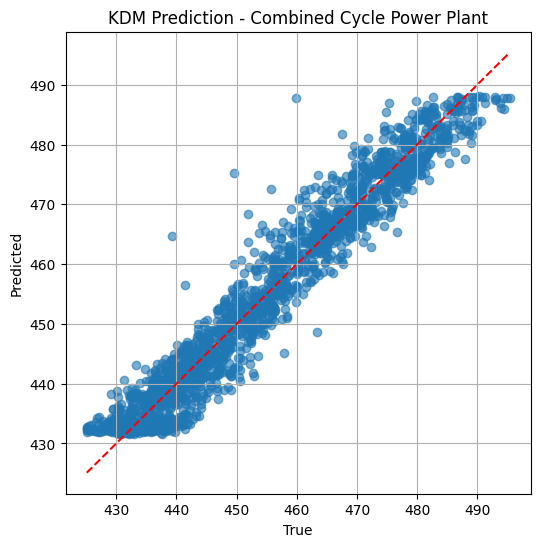

In [16]:
y_pred, y_var = model.predict_reg(x_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

plt.figure(figsize=(6, 6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.6)
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 'r--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('KDM Prediction - Combined Cycle Power Plant')
plt.grid(True)
plt.show()
